In [2]:
import pandas as pd
import numpy as np
import networkx as nx
#from community import community_louvain
import math
import matplotlib.pyplot as plt
from networkx.algorithms import approximation



In [3]:
edges = pd.read_csv("3days.csv", usecols=['from_address', 'to_address'])
G = nx.from_pandas_edgelist(edges, source='from_address', target='to_address', create_using=nx.DiGraph())

In [4]:
edges

,from_address,to_address
0,0x5f67ffa4b3f77dd16c9c34a1a82cab8daea03191,0xeb3a9a839dfeeaf71db1b4ed6a8ae0ccb171b227
1,0x451844bfe5699c70031ab1fd236593a4ed3f4f30,0x451844bfe5699c70031ab1fd236593a4ed3f4f30
2,0x4c9af439b1a6761b8e549d8d226a468a6b2803a8,0xdac17f958d2ee523a2206206994597c13d831ec7
3,0x9fd0d228d9afedf44f262be67217fadf0531152a,0x03df236eacfcef4457ff7d6b88e8f00823014bcd
4,0xc21785dc23f9c6ba623c1b7eef2b2facaaaf858c,0xa67b8e40111a0edd30c3210b77aadb86ad234c43
...,...,...
3344353,0x42928111f6aac60d4be9bbaaec440229aab5b88e,0x4a220e6096b25eadb88358cb44068a3248254675
3344354,0xab36c5322af6560f1cd356c7771224f9a5a9bf22,0xc809dfb3224acf5a777c187f413f3ee1e8a33436
3344355,0x15f8de1e8f702df01b15774e6eb271149f6c4296,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7
3344356,0x82b8c30d4c8f643beb70c976d180a5506f9df582,0x933e9e0deceb9eb6dd538532b458e128ffca74e8


In [11]:
# Esto es para el caso en que se quiera agarrar solo una parte del grafo

# num_filas_total = sum(1 for _ in open("test.csv", 'r'))

# # Calcula el número de filas que representan aproximadamente el 33%
# porcentaje_lectura = 10
# num_filas_a_leer = int(num_filas_total * porcentaje_lectura / 100)

# # Crea un objeto DataFrame leyendo solo las primeras filas
# df = pd.read_csv("test.csv", nrows=num_filas_a_leer)
# G2 = nx.from_pandas_edgelist(df, source='from_address', target='to_address', create_using=nx.DiGraph())

# Cantidad de nodos

In [3]:
total_nodes = G.number_of_nodes()
total_nodes

1079437

# Cantidad de aristas

In [4]:
total_edges = G.number_of_edges()
total_edges

1967524

# Distribución de grados

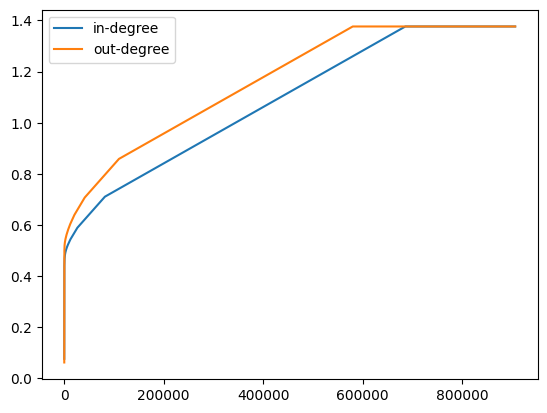

In [14]:
in_degree_values = [G.in_degree(n) for n in G.nodes]
out_degree_values = [G.out_degree(n) for n in G.nodes]

in_degree_values = sorted(in_degree_values, reverse=True)
out_degree_values = sorted(out_degree_values, reverse=True)

in_degree_values = np.array(in_degree_values)
out_degree_values = np.array(out_degree_values)

in_degree_values = in_degree_values / total_nodes
out_degree_values = out_degree_values / total_nodes

in_degree_values = np.cumsum(in_degree_values)
out_degree_values = np.cumsum(out_degree_values)

plt.plot(in_degree_values, label='in-degree')
plt.plot(out_degree_values, label='out-degree')
plt.legend()
plt.show()

# Diametro  

In [15]:
#diameter = nx.diameter(G)
#diameter
# Found infinite path length because the digraph is not strongly connected

# Centralidad

In [7]:
import random
k = 1000
sampled_nodes = random.sample(G.nodes, k)
sampled_graph = G.subgraph(sampled_nodes)


/tmp/ipykernel_9138/3861807955.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(G.nodes, k)


In [15]:

def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x

In [16]:
from multiprocessing import Pool
import time
import itertools
def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), G.order() // node_divisor))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            [None] * num_chunks,
        ),
    )

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

In [17]:
betweenness_centrality = betweenness_centrality_parallel(G)
betweenness_centrality = sorted(betweenness_centrality.values(), reverse=True)
betweenness_centrality = np.array(betweenness_centrality)
betweenness_centrality = betweenness_centrality / total_nodes
betweenness_centrality = np.cumsum(betweenness_centrality)

plt.plot(betweenness_centrality, label='betweenness centrality')
plt.legend()
plt.show()

# Page Rank


PageRank es un algoritmo de clasificación de páginas web desarrollado por Google que se utiliza para medir la importancia relativa de los nodos en una red. En términos simples, PageRank asigna un valor numérico a cada nodo en función de la cantidad y calidad de los enlaces que apuntan a ese nodo. 

In [ ]:
pagerank = nx.pagerank(G)

sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

top_15_pagerank = sorted_pagerank[:15]

for node, value in top_15_pagerank:
    print(f"Nodo: {node}, PageRank: {value}")

Nodo: 0x7f268357a8c2552623316e2562d90e642bb538e5, PageRank: 0.04341578599740294
Nodo: 0xa090e606e30bd747d4e6245a1517ebe430f0057e, PageRank: 0.03522480126861705
Nodo: 0x283af0b28c62c092c9727f1ee09c02ca627eb7f5, PageRank: 0.018834183132894537
Nodo: 0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45, PageRank: 0.016755444569029956
Nodo: 0x4f6742badb049791cd9a37ea913f2bac38d01279, PageRank: 0.014109106449676523
Nodo: 0x28c6c06298d514db089934071355e5743bf21d60, PageRank: 0.013999030413681439
Nodo: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2, PageRank: 0.010029703166251722
Nodo: 0xddfabcdc4d8ffc6d5beaf154f18b778f892a0740, PageRank: 0.00810707929971601
Nodo: 0xfbddadd80fe7bda00b901fbaf73803f2238ae655, PageRank: 0.006463559925874023
Nodo: 0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511, PageRank: 0.005825890220690586
Nodo: 0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7, PageRank: 0.005687234584537239
Nodo: 0x3cd751e6b0078be393132286c442345e5dc49699, PageRank: 0.005643647953573548
Nodo: 0xeb2629a2734e272bcc07bda

# Hub y Autoridad (HITS)


HITS (Hypertext Induced Topic Selection), también conocido como algoritmo de autoridad y hub, es un algoritmo que asigna dos puntajes a cada nodo en un grafo dirigido: el puntaje de hub y el puntaje de autoridad. Los nodos con alto puntaje de hub están vinculados a muchos nodos, y los nodos con alto puntaje de autoridad están vinculados por nodos de alto puntaje de hub.

In [ ]:
hits = nx.hits(G)
hub_scores, authority_scores = hits

top_15_authority = sorted(authority_scores.items(), key=lambda x: x[1], reverse=True)[:15]

for node, value in top_15_authority:
    print(f"Nodo: {node}, Autoridad: {value}")

Nodo: 0x7f268357a8c2552623316e2562d90e642bb538e5, Autoridad: 0.2876756400562207
Nodo: 0x283af0b28c62c092c9727f1ee09c02ca627eb7f5, Autoridad: 0.05752444243139621
Nodo: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2, Autoridad: 0.04329377087994912
Nodo: 0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45, Autoridad: 0.016858521689698966
Nodo: 0x0000000035634b55f3d99b071b5a354f48e10bef, Autoridad: 0.009414287604451878
Nodo: 0x83c8f28c26bf6aaca652df1dbbe0e1b56f8baba2, Autoridad: 0.007396955620984952
Nodo: 0x00000000a50bb64b4bbeceb18715748dface08af, Autoridad: 0.0070192762077757155
Nodo: 0x59728544b08ab483533076417fbbb2fd0b17ce3a, Autoridad: 0.005679489546555953
Nodo: 0x05e7f2499ff153fea2f20bbde0b5584c911c0af1, Autoridad: 0.004801032732245397
Nodo: 0xd62899a44ddd9c57a5320d86c421123f8ec4c6bf, Autoridad: 0.004579797044397803
Nodo: 0xc7457f480416e145093edb355f626faa0fc7f90e, Autoridad: 0.004484478244462076
Nodo: 0x881d40237659c251811cec9c364ef91dc08d300c, Autoridad: 0.004450691570232468
Nodo: 0x2de87c6f15b

# Indice de Katz
El índice de Katz es una medida de centralidad que tiene en cuenta tanto la cantidad de vecinos de un nodo como la importancia de esos vecinos.

In [ ]:
katz = nx.katz_centrality(G)

sorted_katz = sorted(katz.items(), key=lambda x: x[1], reverse=True)

top_15_katz = sorted_katz[:15]

for node, value in top_15_katz:
    print(f"Nodo: {node}, Katz: {value}")

Nodo: 0x7f268357a8c2552623316e2562d90e642bb538e5, Katz: 0.7392476250098514
Nodo: 0x283af0b28c62c092c9727f1ee09c02ca627eb7f5, Katz: 0.35804576538368565
Nodo: 0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45, Katz: 0.17017494530571547
Nodo: 0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2, Katz: 0.14507856332865357
Nodo: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2, Katz: 0.11995163667269185
Nodo: 0xfbddadd80fe7bda00b901fbaf73803f2238ae655, Katz: 0.07548467874434017
Nodo: 0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7, Katz: 0.0485818040945032
Nodo: 0xc098b2a3aa256d2140208c3de6543aaef5cd3a94, Katz: 0.04063228453847006
Nodo: 0x7a250d5630b4cf539739df2c5dacb4c659f2488d, Katz: 0.02812635005756011
Nodo: 0x00000000a50bb64b4bbeceb18715748dface08af, Katz: 0.027667956402856953
Nodo: 0x83c8f28c26bf6aaca652df1dbbe0e1b56f8baba2, Katz: 0.02514754010210005
Nodo: 0xc7457f480416e145093edb355f626faa0fc7f90e, Katz: 0.02506816482449752
Nodo: 0x6262998ced04146fa42253a5c0af90ca02dfd2a3, Katz: 0.024705819743278203
Nodo: 0x0000

In [ ]:
# Coeficiente de clustering
# 1 hora corriendo y no habia terminado, con un dataset de 3 dias

# clustering_coefficients = nx.clustering(G)
# clustering_coefficients = np.array(list(clustering_coefficients.values()))
# clustering_coefficients = np.sort(clustering_coefficients)
# clustering_coefficients = np.cumsum(clustering_coefficients)

# plt.plot(clustering_coefficients)

In [1]:
import pickle 

In [4]:
with open("metrics_2022-05-01.bin", "rb") as file:
    dic = pickle.load(file)

In [5]:
dic

{'total_nodes': 376935,
 'total_edges': 473858,
 'mean_in': 1.257134519214188,
 'max_in': 26410,
 'min_in': 0,
 'mean_out': 1.257134519214188,
 'max_out': 28127,
 'min_out': 0,
 'mean_pagerank': 2.6529773037802632e-06,
 'min_pagerank': 1.3152464948732465e-06,
 'max_pagerank': 0.0304575100365899,
 'mean_hub_score': 2.6529773037791655e-06,
 'min_hub_score': -1.752040540893391e-17,
 'max_hub_score': 0.851064715764008,
 'mean_authority_scores': 2.652977303779167e-06,
 'min_authority_scores': -8.141892059371561e-18,
 'max_authority_scores': 3.723859612835475e-05,
 'mean_value': 2.888696942661286e+18,
 'max_value': 5e+22,
 'mean_nonce': 2965468.889421686,
 'max_nonce': 42454348,
 'min_nonce': 0,
 'mean_gas': 121093.2297112453,
 'max_gas': 26999948,
 'min_gas': 21000}

In [1]:
import pandas as pd 

In [2]:
data = pd.read_csv("registro_metricas_ventanas.csv")

In [3]:
len(data)

183

In [4]:
data['date'].apply(lambda x: x[5:])

0      07-18
1      07-13
2      07-11
3      07-07
4      07-21
       ...  
178    05-04
179    05-06
180    05-15
181    05-05
182    05-13
Name: date, Length: 183, dtype: object

In [10]:
data['month&day'] = data['date'].apply(lambda x: x[5:])
data['year'] = data['date'].apply(lambda x: x[:4])

In [30]:
data

,total_nodes,total_edges,mean_in,max_in,min_in,mean_out,max_out,min_out,mean_pagerank,min_pagerank,...,max_value,mean_nonce,max_nonce,min_nonce,mean_gas,max_gas,min_gas,date,month&day,year
0,390484,458073,1.173090,32301,0,1.173090,20538,0,0.000003,0.000001,...,5.531500e+22,2.399854e+06,43986903,0,129559.342599,28527830,21000,2022-07-18,07-18,2022
1,371134,439229,1.183478,38448,0,1.183478,18578,0,0.000003,0.000001,...,6.399900e+22,2.218696e+06,43887741,0,126091.711042,28527830,21000,2022-07-13,07-13,2022
2,334661,400724,1.197403,37752,0,1.197403,18880,0,0.000003,0.000001,...,5.500000e+22,2.373063e+06,43850376,0,144248.964228,28555688,21000,2022-07-11,07-11,2022
3,371843,449281,1.208255,33437,0,1.208255,19104,0,0.000003,0.000001,...,1.500000e+23,2.272898e+06,43774975,0,122197.394379,23981052,21000,2022-07-07,07-07,2022
4,395385,465691,1.177817,50747,0,1.177817,20156,0,0.000003,0.000001,...,3.913390e+23,2.299253e+06,44047351,0,128248.334704,28555661,21000,2022-07-21,07-21,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,304854,376956,1.236513,41220,0,1.236513,6720,0,0.000003,0.000002,...,1.136543e+23,5.938571e+05,11351421,0,154112.415091,29669455,21000,2023-05-04,05-04,2023
179,310176,393052,1.267190,52524,0,1.267190,8473,0,0.000003,0.000002,...,2.000000e+23,6.433105e+05,11351797,0,154069.398923,28500000,21000,2023-05-06,05-06,2023
180,312054,383353,1.228483,29201,0,1.228483,5927,0,0.000003,0.000002,...,4.409600e+22,5.061312e+05,11358610,0,154141.190272,21078547,21000,2023-05-15,05-15,2023
181,349373,438311,1.254565,52391,0,1.254565,8851,0,0.000003,0.000001,...,1.600000e+23,7.179768e+05,11351674,0,136796.550285,28500000,21000,2023-05-05,05-05,2023


In [13]:
both_data = data.merge(data, on='month&day')

In [25]:
both_data

,total_nodes_x,total_edges_x,mean_in_x,max_in_x,min_in_x,mean_out_x,max_out_x,min_out_x,mean_pagerank_x,min_pagerank_x,...,mean_value_y,max_value_y,mean_nonce_y,max_nonce_y,min_nonce_y,mean_gas_y,max_gas_y,min_gas_y,date_y,year_y
0,390484,458073,1.173090,32301,0,1.173090,20538,0,0.000003,0.000001,...,5.326022e+18,5.531500e+22,2.399854e+06,43986903,0,129559.342599,28527830,21000,2022-07-18,2022
1,390484,458073,1.173090,32301,0,1.173090,20538,0,0.000003,0.000001,...,2.383482e+18,6.121645e+22,6.871865e+05,45650793,0,131922.065483,28537539,21000,2023-07-18,2023
2,350089,417194,1.191680,19922,0,1.191680,6701,0,0.000003,0.000001,...,5.326022e+18,5.531500e+22,2.399854e+06,43986903,0,129559.342599,28527830,21000,2022-07-18,2022
3,350089,417194,1.191680,19922,0,1.191680,6701,0,0.000003,0.000001,...,2.383482e+18,6.121645e+22,6.871865e+05,45650793,0,131922.065483,28537539,21000,2023-07-18,2023
4,371134,439229,1.183478,38448,0,1.183478,18578,0,0.000003,0.000001,...,4.916605e+18,6.399900e+22,2.218696e+06,43887741,0,126091.711042,28527830,21000,2022-07-13,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,391642,456898,1.166622,20858,0,1.166622,18261,0,0.000003,0.000001,...,9.320931e+18,9.000000e+22,2.621967e+06,42663053,0,122364.288084,26999999,21000,2022-05-11,2022
361,391642,456898,1.166622,20858,0,1.166622,18261,0,0.000003,0.000001,...,3.013292e+18,3.357364e+22,5.742092e+05,11357441,0,148866.749461,22332300,21000,2023-05-11,2023
362,298809,370945,1.241412,40154,0,1.241412,6622,0,0.000003,0.000002,...,9.320931e+18,9.000000e+22,2.621967e+06,42663053,0,122364.288084,26999999,21000,2022-05-11,2022
363,298809,370945,1.241412,40154,0,1.241412,6622,0,0.000003,0.000002,...,3.013292e+18,3.357364e+22,5.742092e+05,11357441,0,148866.749461,22332300,21000,2023-05-11,2023


In [16]:
filtro = both_data.apply(lambda x: False if x.year_x == x.year_y else True, axis=1)

In [27]:
final = both_data[filtro].drop_duplicates(subset=['month&day'])

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
def plot_time_series(valor, data):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=data['month&day'], y=data[valor], color='blue', hue=data['year'])
    # Configurar etiquetas y título
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15))
    plt.gcf().set_facecolor('white')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title(f'{valor}')
    plt.legend()
    plt.grid(True)

    # Mostrar el gráfico
    plt.show()

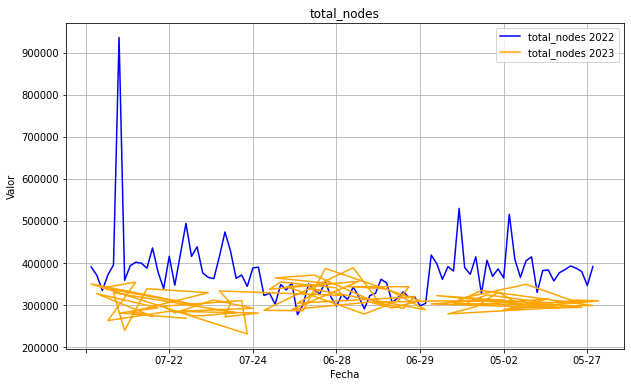

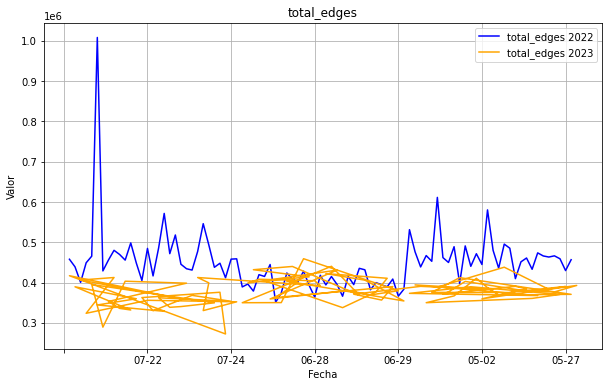

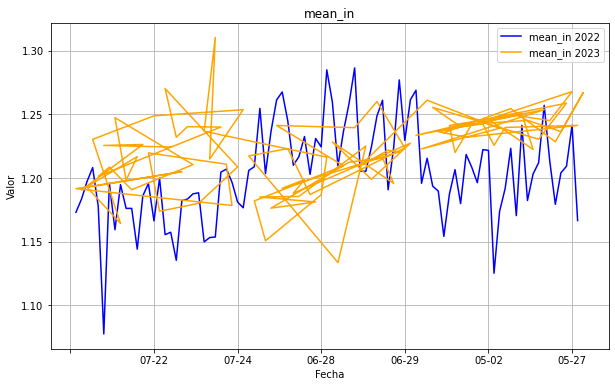

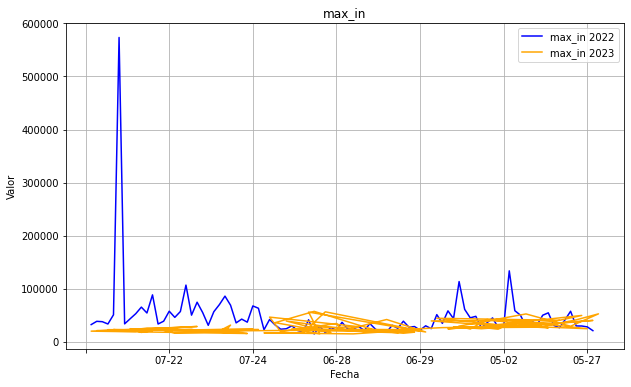

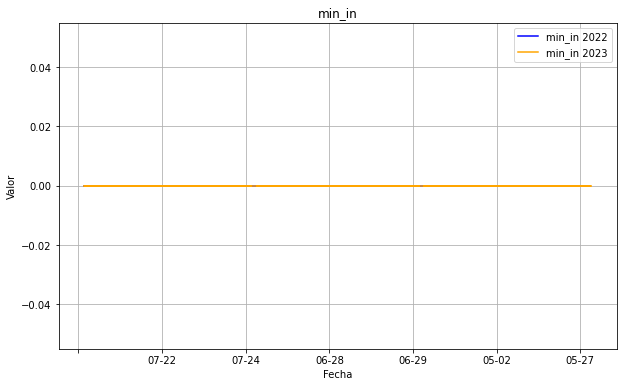

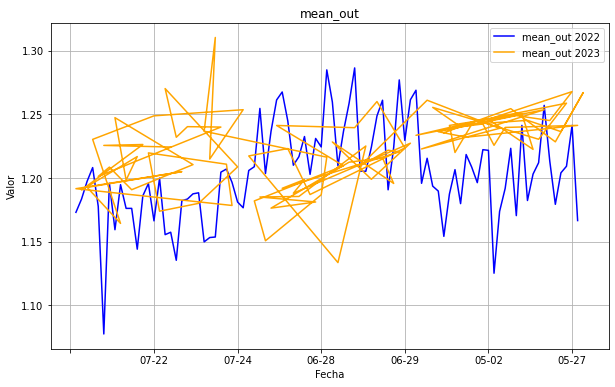

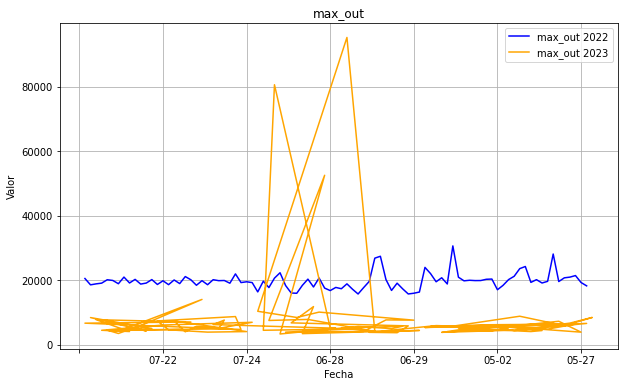

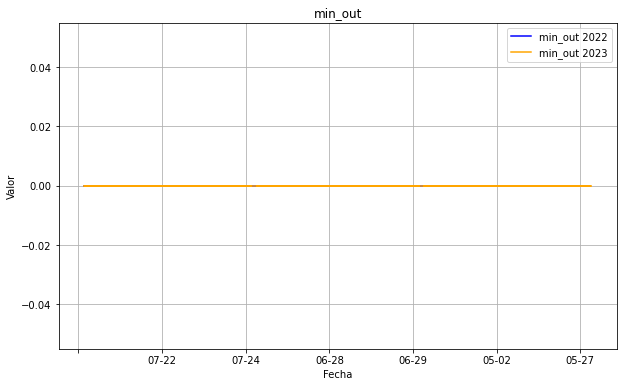

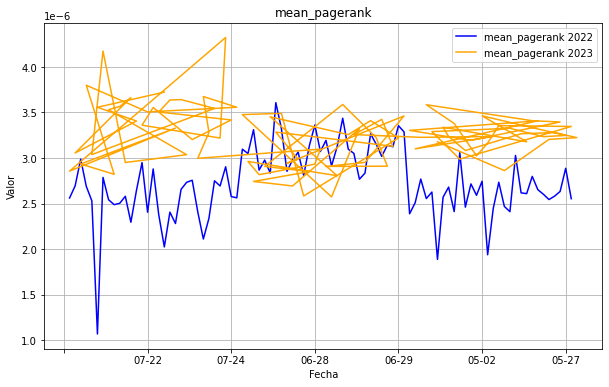

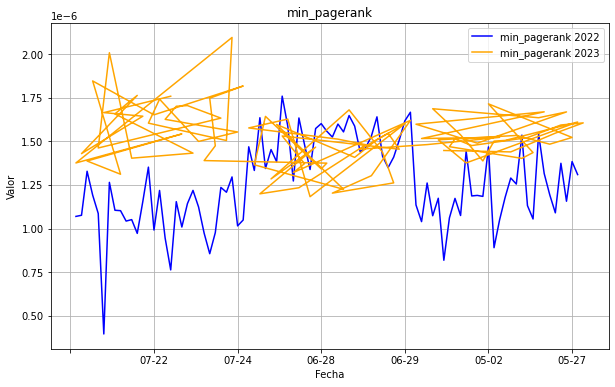

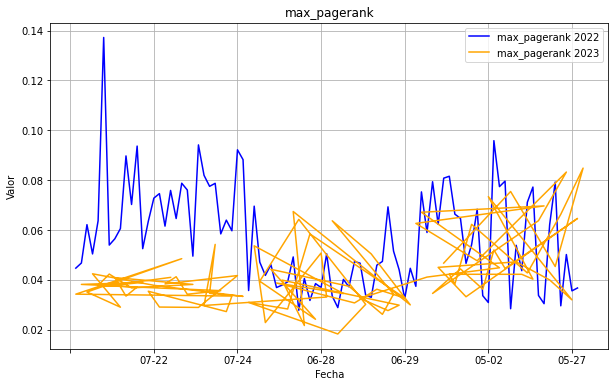

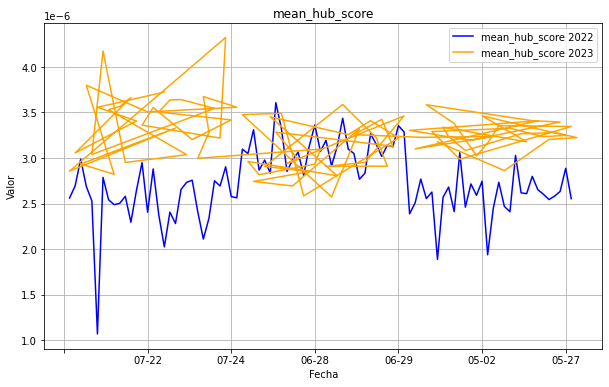

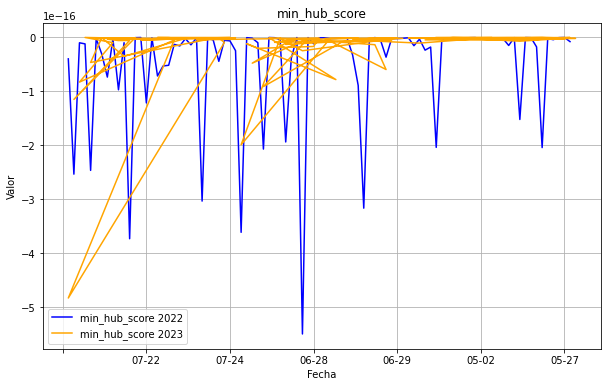

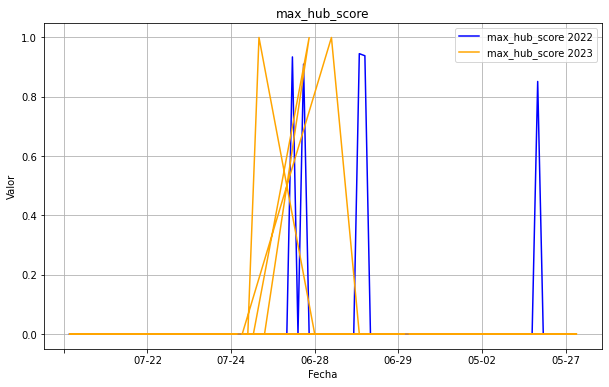

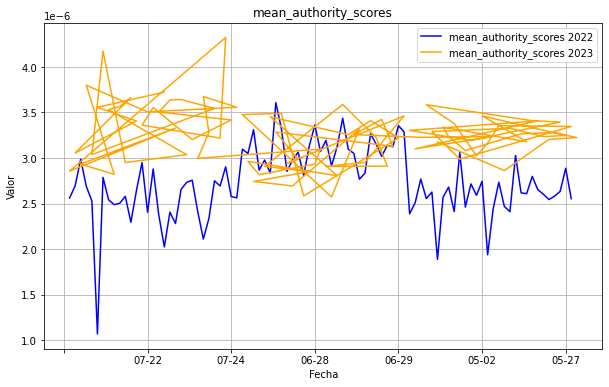

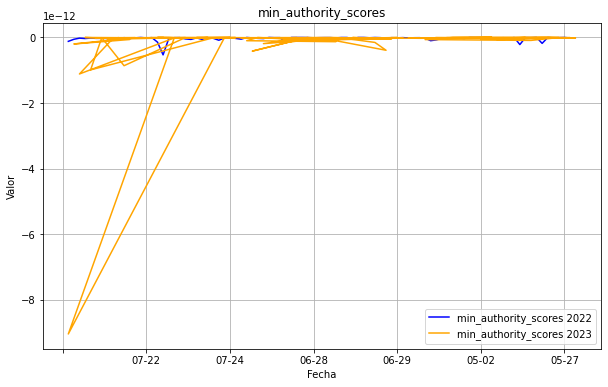

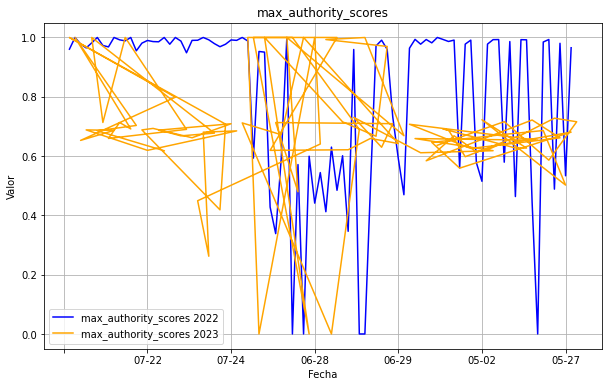

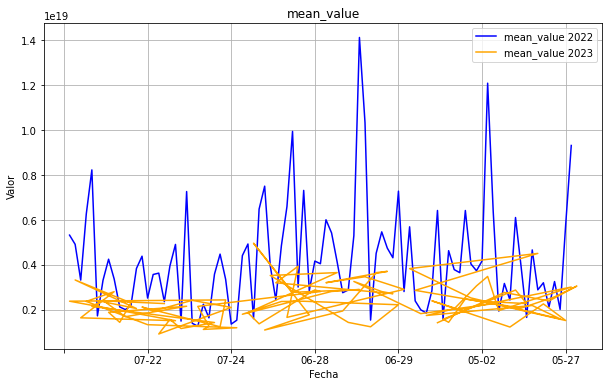

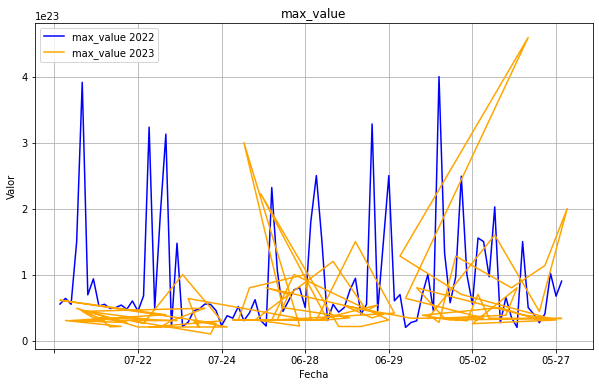

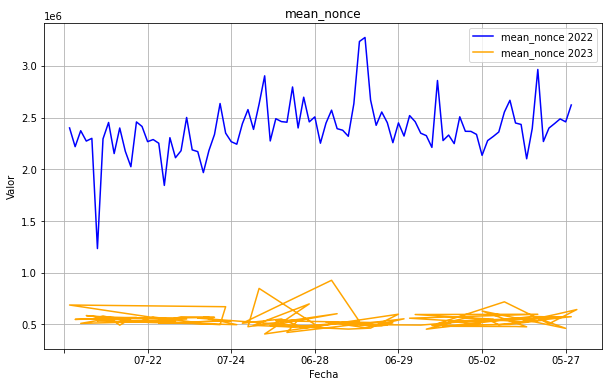

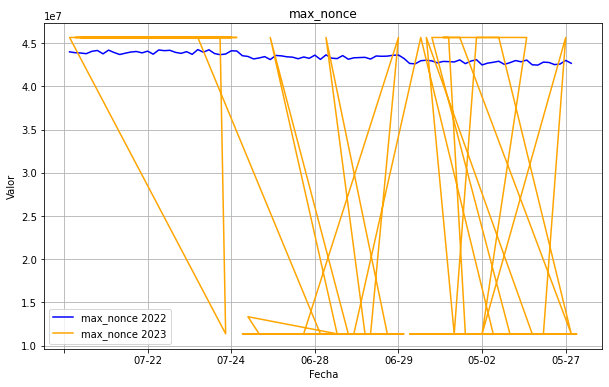

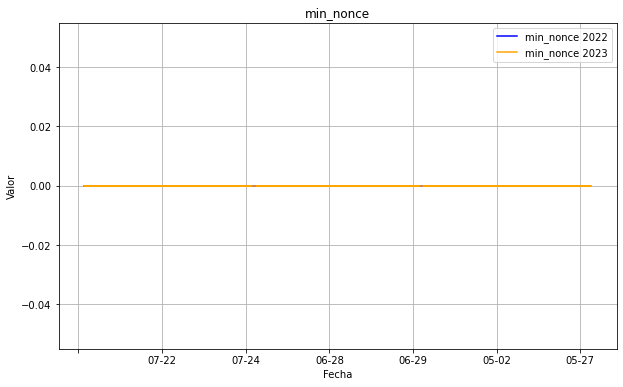

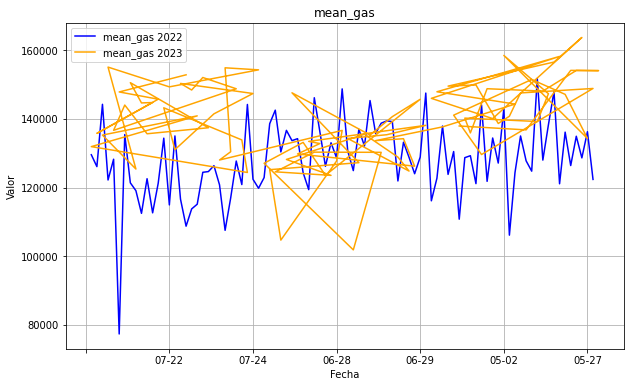

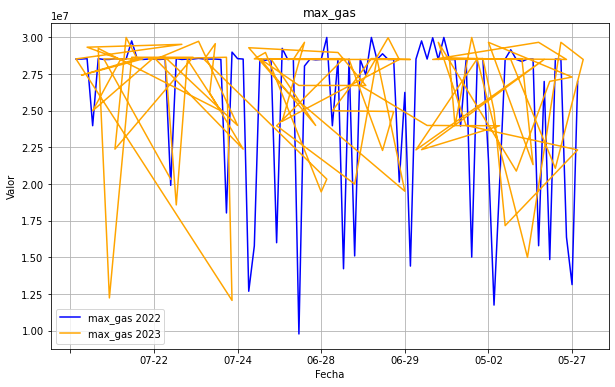

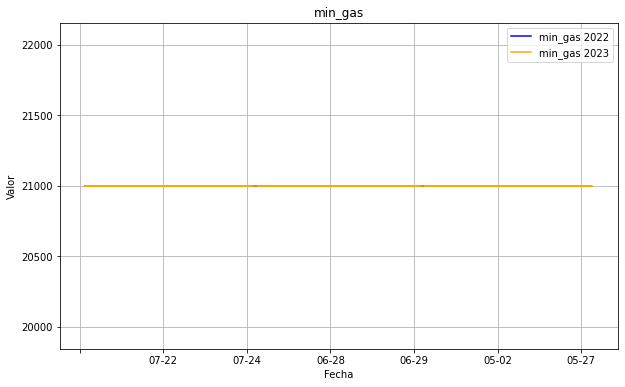

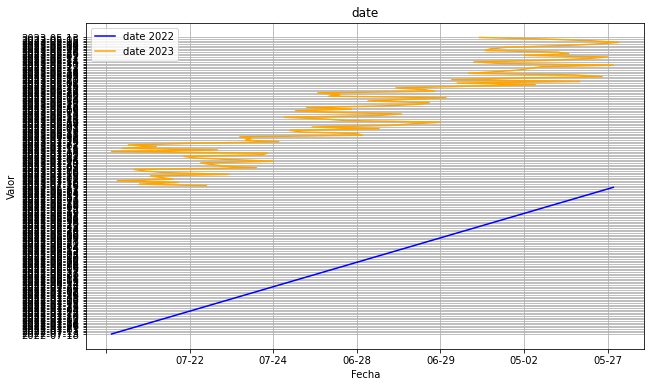

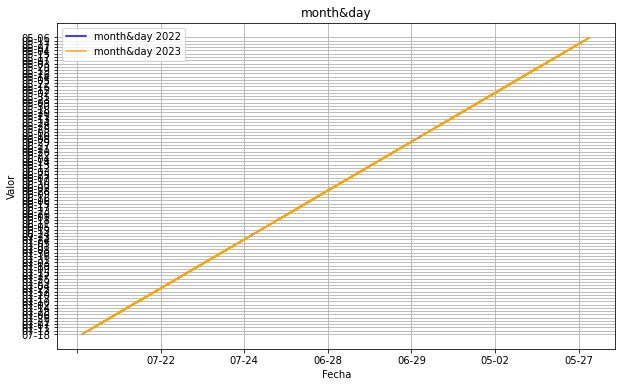

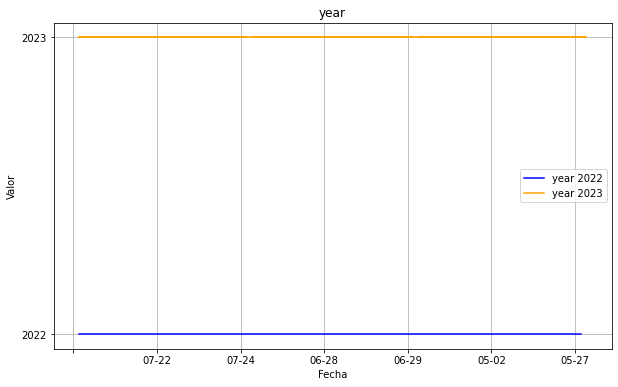

In [34]:
for col in data.columns:
    plot_time_series(col, data)

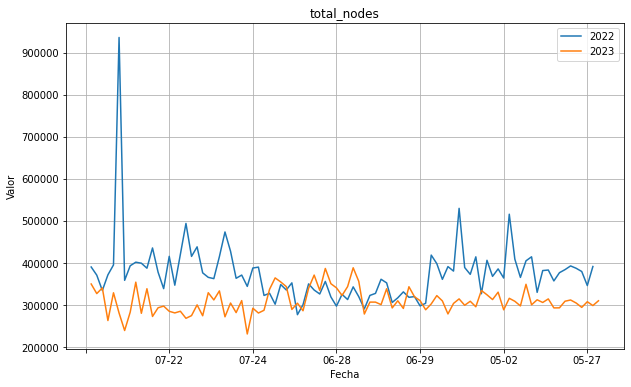

In [59]:
plot_time_series('total_nodes', data)

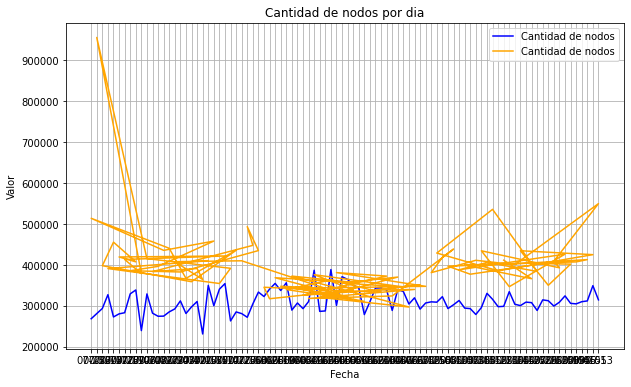

In [46]:
nuevo = data[data.year == '2023']
nuevo2 = data[data.year == '2022']
plt.figure(figsize=(10, 6))
plt.plot(nuevo['month&day'], nuevo['total_nodes'], label='Cantidad de nodos', color='blue')
plt.plot(nuevo2['month&day'], nuevo2['total_nodes']+20000, label='Cantidad de nodos', color='orange')
# Configurar etiquetas y título
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15))
plt.gcf().set_facecolor('white')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cantidad de nodos por dia')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


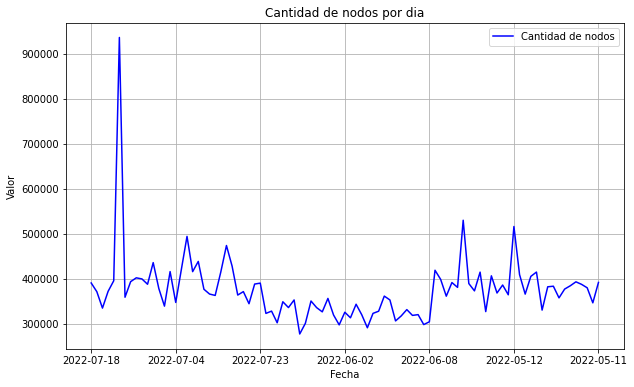

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(data.date, data['total_nodes'], label='Cantidad de nodos', color='blue')

# Configurar etiquetas y título
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15))
plt.gcf().set_facecolor('white')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cantidad de nodos por dia')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


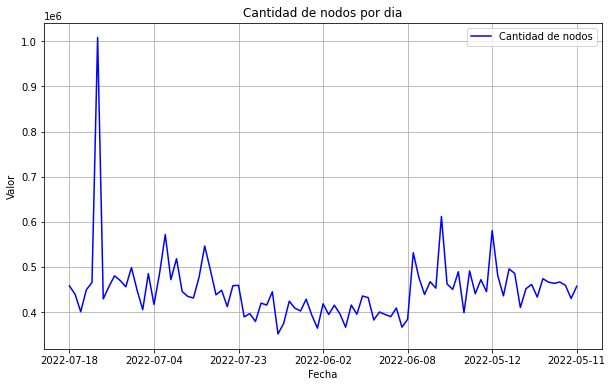

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(data.date, data['total_edges'], label='Cantidad de nodos', color='blue')

# Configurar etiquetas y título
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15))
plt.gcf().set_facecolor('white')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cantidad de nodos por dia')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [2]:
import pandas as pd

In [4]:
data = pd.read_csv('registro_metricas_ventanas22_23.csv')

In [75]:
data[['mean_pagerank', 'mean_authority_scores', 'mean_hub_score']]

,mean_pagerank,mean_authority_scores,mean_hub_score
101,0.000003,0.000003,0.000003
30,0.000003,0.000003,0.000003
0,0.000003,0.000003,0.000003
105,0.000003,0.000003,0.000003
97,0.000003,0.000003,0.000003
...,...,...,...
161,0.000004,0.000004,0.000004
66,0.000002,0.000002,0.000002
178,0.000003,0.000003,0.000003
69,0.000002,0.000002,0.000002


In [5]:
data['month&day'] = data['date'].apply(lambda x: x[5:])
data['year'] = data['date'].apply(lambda x: x[:4])

import matplotlib.pyplot as plt
import seaborn as sns


In [73]:
data = data.sort_values(by='month&day')

In [78]:
data['mean_in']

101    1.253741
30     1.257135
0      1.221792
105    1.246164
97     1.230512
         ...   
161    1.270346
66     1.153697
178    1.310485
69     1.149872
169    1.236809
Name: mean_in, Length: 184, dtype: float64

In [96]:
blue['month&day']

NameError: name 'blue' is not defined

In [210]:
def plot_time_series(valor, data):
    fig, axs = plt.subplots(ncols=3, figsize=(20, 12))
    fig.suptitle("")
    dias = list(data['month&day'])
    ticks = [i for i in range(0, 91, 10)]
    labels = [dias[i] for i in range(0, 91, 10)]
    # Lineplot principal
    sns.lineplot(x='month&day', y=valor, color='blue', hue='year', data=data, ax=axs[0][0])
    plt.gcf().set_facecolor('white')
    axs[0][0].set_xlabel('Fecha')
    axs[0][0].set_ylabel('Valor')
    axs[0][0].set_title(f'{valor}')
    axs[0][0].legend()
    axs[0][0].grid(True)
    axs[0][0].set_xticks(ticks, labels=labels, rotation=45)
    
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15))

    # Filtrar datos por año
    blue = data[data['year'] == '2023']
    orange = data[data['year'] == '2022']
    
    # Calcular intervalos de desviación estándar
    lower_blue = blue[valor] - blue['std_'+ valor[5:]]
    upper_blue = blue[valor] + blue['std_'+ valor[5:]]
    lower_orange = orange[valor] - orange['std_'+ valor[5:]]
    upper_orange = orange[valor] + orange['std_'+ valor[5:]]
    

    axs[1].fill_between(blue['month&day'], lower_blue.values, upper_blue.values, alpha=.3, color='blue', label='2023 Std Dev')
    axs[1].set_xticks(ticks, labels=labels, rotation=45)
    axs[1].set_xlabel('Fecha')
    axs[1].set_ylabel('Valor')
    axs[1].set_title(f'{valor}')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(-600, 600) 
    axs[2].fill_between(orange['month&day'].values, lower_orange, upper_orange, alpha=.3, color='orange', label='2022 Std Dev')
    axs[2].set_xticks(ticks, labels=labels, rotation=45)
    axs[2].set_xlabel('Fecha')
    axs[2].set_ylabel('Valor')
    axs[2].set_title(f'{valor}')
    axs[2].legend()
    axs[2].set_ylim(-600, 600) 
    axs[2].grid(True)
    

    # Mostrar el gráfico
    plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

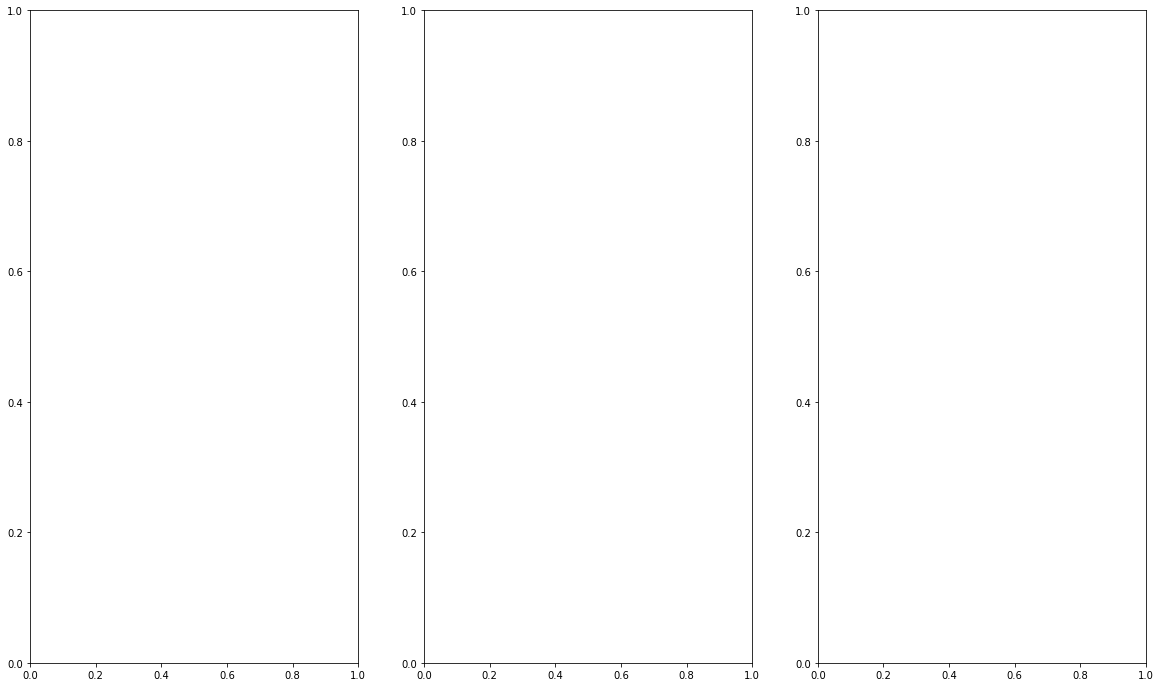

In [211]:
plot_time_series('mean_in', data)

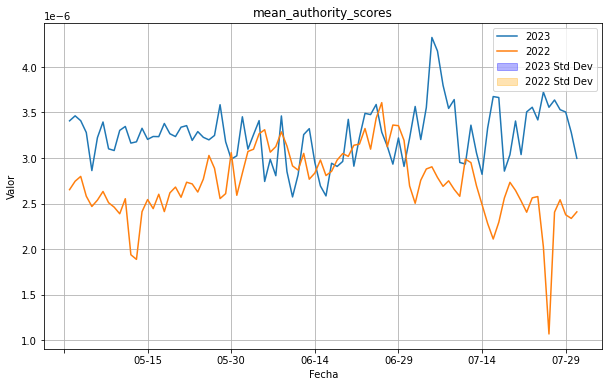

In [71]:
plot_time_series('mean_authority_scores', data)

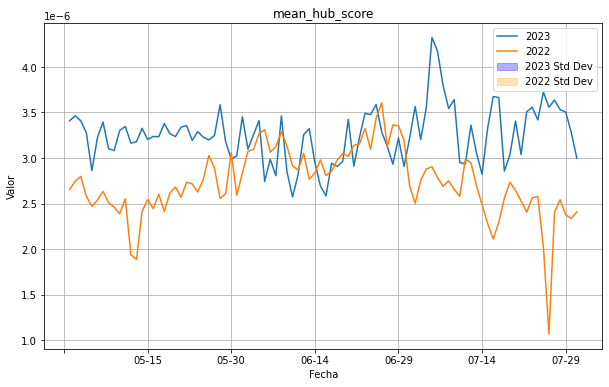

In [72]:
plot_time_series('mean_hub_score', data)